In [ ]:
!pip install pandas scikit-learn nltk matplotlib seaborn ipywidgets
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import sys
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets
from IPython.display import display

nltk.download('stopwords')

 # --- Configuration ---
DATASET_PATH = 'IMDB Dataset.csv' # Assuming the file is directly uploaded
MODEL_FILENAME = 'sentiment_analysis_model.pkl'
NLTK_STOPWORDS = set(stopwords.words('english'))

 # Load data
try:
     df = pd.read_csv(DATASET_PATH)
     print("Data loaded successfully.")
     print(f"Dataset shape: {df.shape}")
     print("\nSample Data:")
     print(df.head())
except FileNotFoundError:
     print(f"Error: The file '{DATASET_PATH}' was not found. Make sure you have uploaded it.")
     sys.exit(1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data loaded successfully.
Dataset shape: (50000, 2)

Sample Data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive



--- Exploratory Data Analysis ---


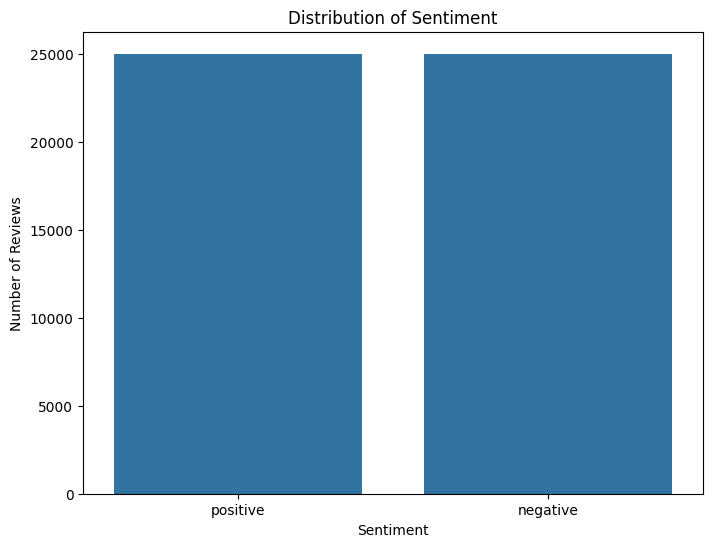


Sentiment Value Counts:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


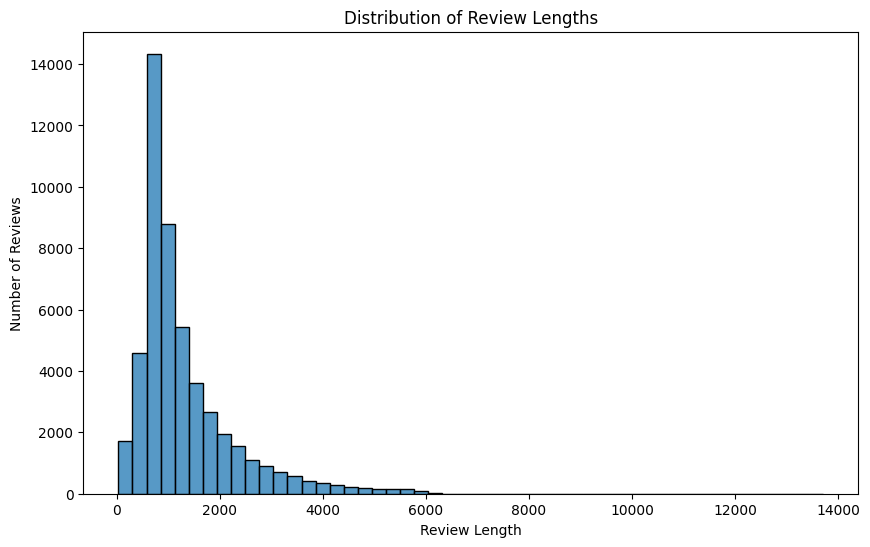


Average Review Length: 1309.43

Most Common Words (before preprocessing):
[('the', 638861), ('a', 316615), ('and', 313637), ('of', 286661), ('to', 264573), ('is', 204876), ('in', 179807), ('i', 141587), ('this', 138483), ('that', 130140), ('it', 129614), ('/><br', 100974), ('was', 93258), ('as', 88242), ('with', 84590), ('for', 84510), ('but', 77864), ('on', 62890), ('movie', 61492), ('are', 57009)]


In [ ]:
# --- Exploratory Data Analysis ---
print("\n--- Exploratory Data Analysis ---")

 # 1. Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()
print(f"\nSentiment Value Counts:\n{df['sentiment'].value_counts()}")

 # 2. Review Length Analysis
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()
print(f"\nAverage Review Length: {df['review_length'].mean():.2f}")

 # 3. Most Frequent Words (before preprocessing)
from collections import Counter
all_words = ' '.join(df['review']).lower().split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)
print("\nMost Common Words (before preprocessing):")
print(most_common_words)

df.drop(columns=['review_length'], inplace=True) # Drop the temporary column

In [ ]:
# --- Text Preprocessing Function ---
def preprocess_text(text):
     """Cleans and preprocesses a single text review."""
     text = text.lower()
     clean_text = re.sub(r'<br\s*/>', ' ', text)
     clean_text = re.sub(r'[^a-z\s]', '', clean_text)
     tokens = clean_text.split()
     filtered_tokens = [word for word in tokens if word not in NLTK_STOPWORDS]
     return ' '.join(filtered_tokens)

 # Apply preprocessing to the 'review' column
print("\nPreprocessing text data...")
df['processed_review'] = df['review'].apply(preprocess_text)
print("Text preprocessing complete.")


Preprocessing text data...
Text preprocessing complete.


In [ ]:
# --- Data Splitting ---
X = df['processed_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)} reviews")
print(f"Testing set size: {len(X_test)} reviews")

Training set size: 40000 reviews
Testing set size: 10000 reviews


In [ ]:
# --- Model Training and Evaluation ---
print("\n--- Model Training and Evaluation ---")

 # Define the pipeline
pipeline = Pipeline([
     ('tfidf', TfidfVectorizer()),
     ('classifier', LogisticRegression(solver='liblinear', random_state=42))
 ])

 # Train the model
print("\nTraining the Logistic Regression model...")
pipeline.fit(X_train, y_train)
print("Model training complete.")

 # Evaluate the model
print("\nEvaluating the model on the test set...")
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

 # --- Hyperparameter Tuning (if performance < 85%) ---
if accuracy < 0.85 or f1 < 0.85:
     print("\n--- Hyperparameter Tuning ---")
     print("Initial performance is below 85%, performing hyperparameter tuning...")

     param_grid = {
         'tfidf__ngram_range': [(1, 1), (1, 2)],
         'tfidf__max_df': [0.8, 0.9],
         'classifier__C': [0.1, 1, 10]
     }

     grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
     grid_search.fit(X_train, y_train)

     print("\nBest Hyperparameters:", grid_search.best_params_)
     best_model = grid_search.best_estimator_

     # Evaluate the best model
     y_pred_best = best_model.predict(X_test)
     accuracy_best = accuracy_score(y_test, y_pred_best)
     f1_best = f1_score(y_test, y_pred_best)

     print(f"\nBest Model Accuracy: {accuracy_best:.4f}")
     print(f"Best Model F1-Score: {f1_best:.4f}")
     print("\nBest Model Classification Report:")
     print(classification_report(y_test, y_pred_best, target_names=['negative', 'positive']))

     # Save the best model
     joblib.dump(best_model, MODEL_FILENAME)
     print(f"\nBest model saved as '{MODEL_FILENAME}'.")
     model_to_use = best_model

else:
     # Save the initial model if performance is good enough
     joblib.dump(pipeline, MODEL_FILENAME)
     print(f"\nModel saved as '{MODEL_FILENAME}'.")
     model_to_use = pipeline


--- Model Training and Evaluation ---

Training the Logistic Regression model...
Model training complete.

Evaluating the model on the test set...
Accuracy: 0.8948
F1-Score: 0.8956

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      5000
    positive       0.89      0.90      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Model saved as 'sentiment_analysis_model.pkl'.
